#### Load modules

Install Detectron2 from [Facebook's Research Github](https://github.com/facebookresearch/detectron2) and, Imprep preferably, in a new conda environment.



In [1]:
import imageprep as imp
from imageprep import coco, yolo
import itertools
import detectron2
import os
import cv2
import numpy as np
from detectron2.structures import BoxMode
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

Detectron2 Requires each bounding box to have structure mode and since is a unique case, here is a update the dictionary returned with imageprep.


### Data

In [2]:
def abs_coco_from_yolo_for_detectron2(img_dir, label_dir, bbox_mode='BoxMode.XYWH_REL'):
    """
     Creates Detectron2 compatible COCO data format

    :param img_dir: Path to the image containing images
    :param label_dir: Path to the corresponding labels
    :param bbox_mode: Detectron2 specification for the value of bbox.
    :return: Python dictionary
    """
    data_dict = coco.coco_format_folder(img_dir, label_dir)
    dataset_dicts = []
    for idx, v in enumerate(data_dict):

        record = {}
        file_name = v['image'][0]['file_name']
        height = v['image'][0]['height']
        width = v['image'][0]['width']

        record["file_name"] = file_name
        record["height"] = height
        record["width"] = width
        record["image_id"] = idx

        annotations = v['annotations']
        for j, b in enumerate(annotations):
            category_id = b['bbox'][0]

            xmin = b['bbox'][1]
            ymin = b['bbox'][2]
            xmax = b['bbox'][3]
            ymax = b['bbox'][4]
            
            new_bbox = [xmin, ymin, xmax, ymax]
            abs_bbox = yolo.reverse_yolo_to_absolute((height,width), new_bbox)
            
            nxmin = abs_bbox[0]
            nymin = abs_bbox[1]
            nxmax = abs_bbox[2]
            nymax = abs_bbox[3]
            
            poly = [
                (nxmin, nymin), (nxmax, nymin),
                (nxmax, nymax), (nxmin, nymax)
            ]
            
            poly = list(itertools.chain.from_iterable(poly))
            
            annotations[j]['bbox'] = abs_bbox
            annotations[j]['bbox_mode'] = bbox_mode
            annotations[j]['category_id'] = category_id
            annotations[j]['segmentation'] = [poly]

            record["annotations"] = annotations
        dataset_dicts.append(record)

    return dataset_dicts

### Absolute Value Labels

In [3]:
image_path = '../data/images/'
label_path = '../data/labels/'

dataset_dicts = coco.coco_for_detectron2(image_path, label_path,  bbox_mode=BoxMode.XYXY_ABS)
dataset_dicts

[{'file_name': '../data/images/145_28.jpg',
  'height': 416,
  'width': 416,
  'image_id': 0,
  'annotations': [{'bbox': [336, 398, 416, 416],
    'id': 1,
    'segmentation': [[336, 398, 416, 398, 416, 416, 336, 416]],
    'area': 1440,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>},
   {'bbox': [3, 91, 105, 163],
    'id': 2,
    'segmentation': [[336, 398, 416, 398, 416, 416, 336, 416]],
    'area': 7344,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>},
   {'bbox': [134, 31, 196, 95],
    'id': 3,
    'segmentation': [[336, 398, 416, 398, 416, 416, 336, 416]],
    'area': 3968,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>}]},
 {'file_name': '../data/images/79_38.jpg',
  'height': 416,
  'width': 416,
  'image_id': 1,
  'annotations': [{'bbox': [257, 306, 325, 370],
    'id': 1,
    'segmentation': [[257, 306, 325, 306, 325, 370, 257, 370]],
    'area': 4352,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>}]},
 {'file_name': '

#### Check Data

In [5]:
plane_metadata = MetadataCatalog.get(image_path).set(thing_classes=["Plane"])

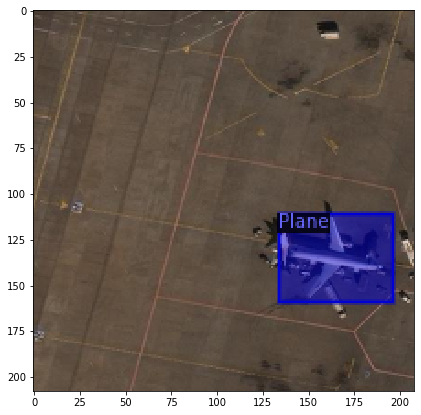

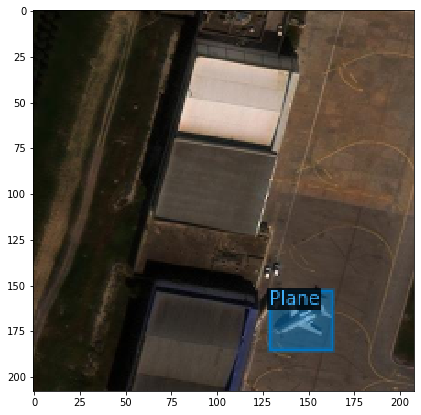

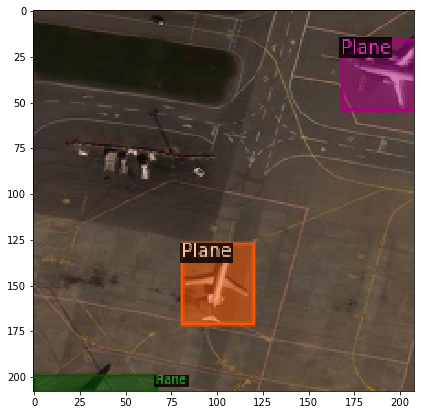

In [6]:
# Plot image and metdata
for d in random.sample(dataset_dicts, 3):

    file_name = d['file_name']
    img = cv2.imread(file_name)
    plt.figure(figsize=(7,7))
    visualizer = Visualizer(img[:, :, ::-1], metadata=plane_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())

### Relative Value (YOLO) labels

Relative Value is not currently supported by Detectron2. In ImagePrep, these values will be converted to Absolute from Relative before creating the dictionary.

In [3]:
image_path = '../data/images/'
label_path = '../data/yolo_labels/'

dataset_dicts2 = coco.coco_from_yolo_for_detectron2(image_path, label_path,  bbox_mode=BoxMode.XYXY_ABS)
dataset_dicts2

[{'file_name': '../data/images/145_28.jpg',
  'height': 416,
  'width': 416,
  'image_id': 0,
  'annotations': [{'bbox': (336, 398, 416, 416),
    'id': 1,
    'segmentation': [[336, 398, 416, 398, 416, 416, 336, 416]],
    'area': 0,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>},
   {'bbox': (3, 91, 105, 163),
    'id': 2,
    'segmentation': [[3, 91, 105, 91, 105, 163, 3, 163]],
    'area': 0,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>},
   {'bbox': (134, 31, 196, 95),
    'id': 3,
    'segmentation': [[134, 31, 196, 31, 196, 95, 134, 95]],
    'area': 0,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>}]},
 {'file_name': '../data/images/79_38.jpg',
  'height': 416,
  'width': 416,
  'image_id': 1,
  'annotations': [{'bbox': (257, 306, 325, 370),
    'id': 1,
    'segmentation': [[257, 306, 325, 306, 325, 370, 257, 370]],
    'area': 0,
    'category_id': 0,
    'bbox_mode': <BoxMode.XYXY_ABS: 0>}]},
 {'file_name': '../data/images/79_45.j

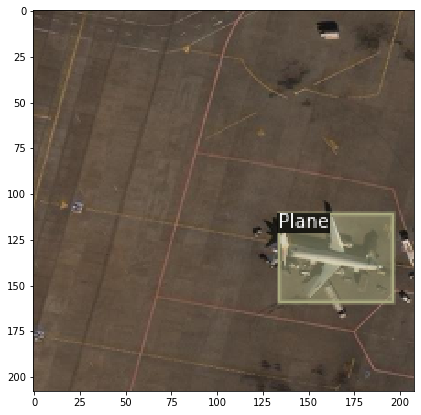

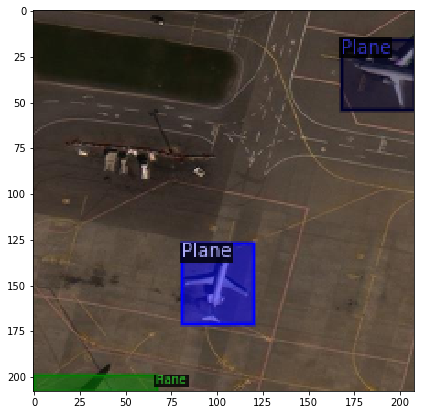

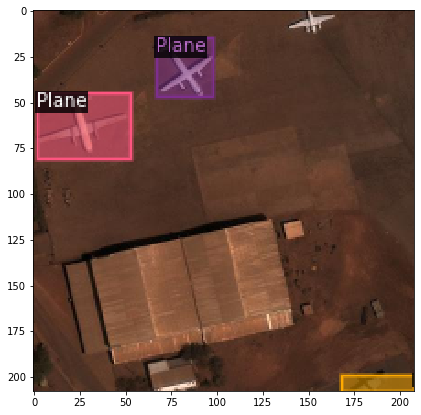

In [7]:
# Plot image and metdata
for d in random.sample(dataset_dicts2, 3):

    file_name = d['file_name']
    img = cv2.imread(file_name)
    plt.figure(figsize=(7,7))
    visualizer = Visualizer(img[:, :, ::-1], metadata=plane_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())